In [32]:
!pip install -q pandas requests matplotlib seaborn numpy datetime scikit-learn

In [34]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


DATASET

In [37]:
url_train = "https://raw.githubusercontent.com/Neurolake/challenge-data-scientist/main/datasets/credit_01/train.gz"
response = requests.get(url_train)
df_train = pd.read_csv(io.BytesIO(response.content), compression='gzip')

url_test = "https://raw.githubusercontent.com/Neurolake/challenge-data-scientist/main/datasets/credit_01/test.gz"
response = requests.get(url_test)
df_test = pd.read_csv(io.BytesIO(response.content), compression='gzip')

url_oot = "https://raw.githubusercontent.com/Neurolake/challenge-data-scientist/main/datasets/credit_01/oot.gz"
response = requests.get(url_oot)
df_oot = pd.read_csv(io.BytesIO(response.content), compression='gzip')

print("Tamanho do dataset de treino: ", len(df_train))
print("Tamanho do dataset de teste: ", len(df_test))
print("Tamanho do dataset de oot: ", len(df_oot))

Tamanho do dataset de treino:  120750
Tamanho do dataset de teste:  51751
Tamanho do dataset de oot:  91965


In [38]:
print(df_train.shape, df_test.shape, df_oot.shape)

(120750, 151) (51751, 151) (91965, 150)


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 139.1+ MB


In [88]:
# Evidenciando variáveis com ausência de valores
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
           print('Variável: %s - UNFULL' %col) 

Variável: VAR2 - UNFULL
Variável: IDADE - UNFULL
Variável: VAR5 - UNFULL
Variável: VAR6 - UNFULL
Variável: VAR7 - UNFULL
Variável: VAR8 - UNFULL
Variável: VAR9 - UNFULL
Variável: VAR10 - UNFULL
Variável: VAR11 - UNFULL
Variável: VAR12 - UNFULL
Variável: VAR13 - UNFULL
Variável: VAR14 - UNFULL
Variável: VAR15 - UNFULL
Variável: VAR16 - UNFULL
Variável: VAR17 - UNFULL
Variável: VAR18 - UNFULL
Variável: VAR19 - UNFULL
Variável: VAR20 - UNFULL
Variável: VAR21 - UNFULL
Variável: VAR22 - UNFULL
Variável: VAR23 - UNFULL
Variável: VAR24 - UNFULL
Variável: VAR25 - UNFULL
Variável: VAR28 - UNFULL
Variável: VAR29 - UNFULL
Variável: VAR30 - UNFULL
Variável: VAR32 - UNFULL
Variável: VAR33 - UNFULL
Variável: VAR34 - UNFULL
Variável: VAR35 - UNFULL
Variável: VAR36 - UNFULL
Variável: VAR37 - UNFULL
Variável: VAR39 - UNFULL
Variável: VAR40 - UNFULL
Variável: VAR41 - UNFULL
Variável: VAR42 - UNFULL
Variável: VAR48 - UNFULL
Variável: VAR49 - UNFULL
Variável: VAR50 - UNFULL
Variável: VAR51 - UNFULL
Variáv

In [9]:
df_train.head(3)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015


In [40]:
print(df_train['TARGET'].value_counts())
print("\nTaxa de inadimplentes:")
print(df_train['TARGET'].mean())

TARGET
0    91163
1    29587
Name: count, dtype: int64

Taxa de inadimplentes:
0.24502691511387165


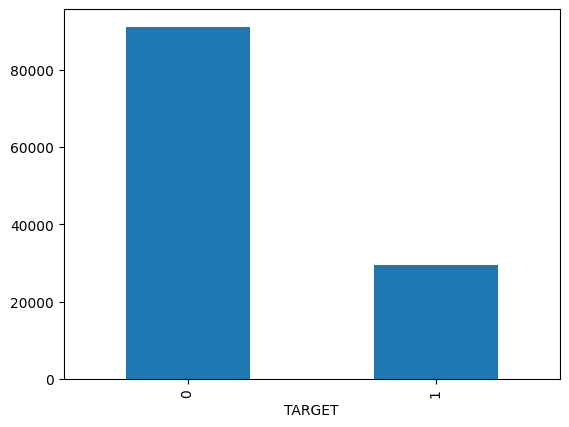

In [41]:
var = 'TARGET'
grafico_barras = df_train[var].value_counts().plot.bar()

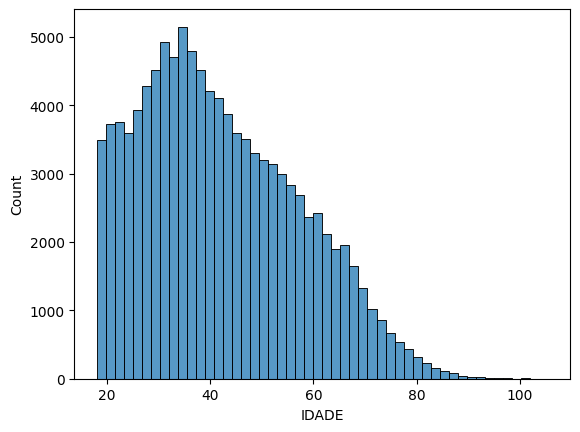

In [12]:
var = "IDADE"

sns.histplot(df_train, x = var, bins = 50)
plt.show()

/tmp/ipykernel_240270/4176947559.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_train.groupby(cat_srs)


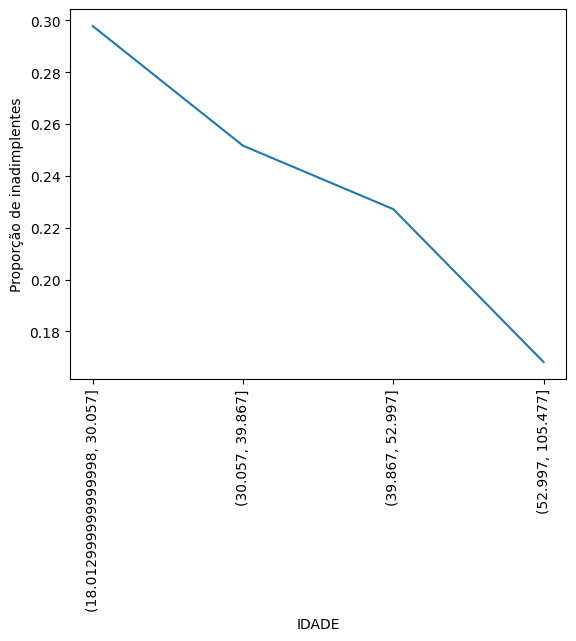

In [42]:
var = 'IDADE'
cat_srs, bins = pd.qcut(df_train[var], 4, retbins=True)
g = df_train.groupby(cat_srs)
biv = g['TARGET'].mean()

ax = biv.plot.line()
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)

In [49]:
# Converter para datetime com tratamento de timezone
df_train['REF_DATE'] = pd.to_datetime(
    df_train['REF_DATE'], 
    utc=True,  # Manter informação de UTC
    format='%Y-%m-%d %H:%M:%S%z'  # Formato explícito com timezone
)

# Criar colunas de mês/ano (já convertendo para o fuso local se necessário)
df_train['MES'] = df_train['REF_DATE'].dt.tz_localize(None).dt.month  # Remove timezone antes de extrair
df_train['ANO'] = df_train['REF_DATE'].dt.tz_localize(None).dt.year

# Verificar conversão
print("\nAmostra da conversão:")
display(df_train[['REF_DATE', 'MES', 'ANO']].head(3))


Amostra da conversão:


,REF_DATE,MES,ANO
0,2017-06-01 00:00:00+00:00,6,2017
1,2017-08-18 00:00:00+00:00,8,2017
2,2017-06-30 00:00:00+00:00,6,2017


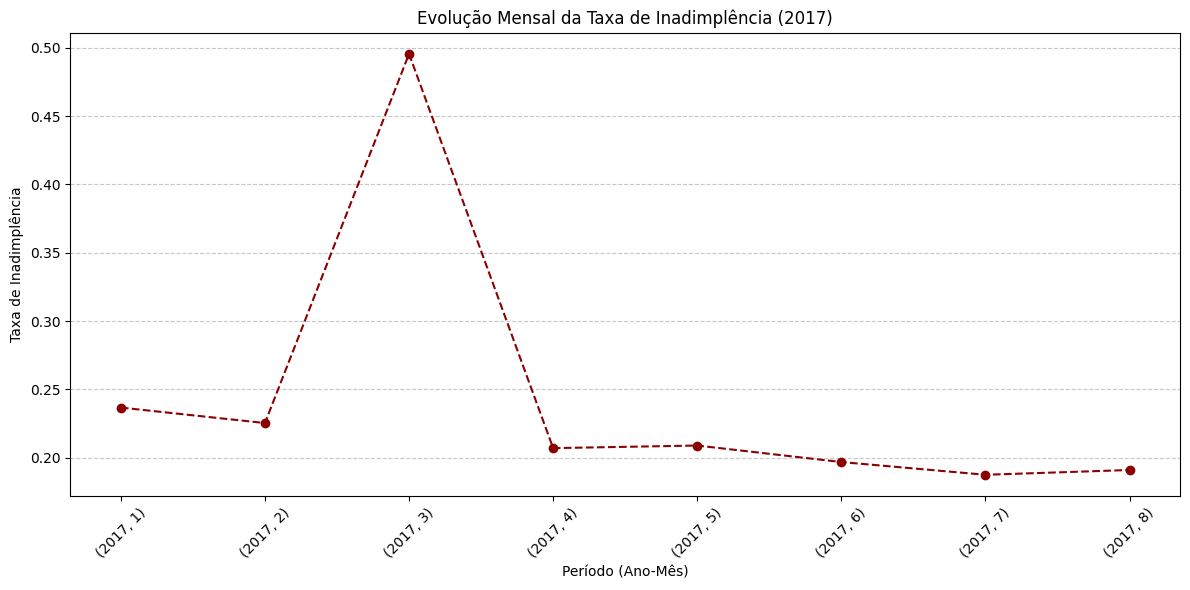

In [50]:
plt.figure(figsize=(12,6))
df_train.groupby(['ANO','MES'])['TARGET'].mean().plot(
    marker='o',
    linestyle='--',
    color='darkred'
)
plt.title('Evolução Mensal da Taxa de Inadimplência (2017)')
plt.ylabel('Taxa de Inadimplência')
plt.xlabel('Período (Ano-Mês)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

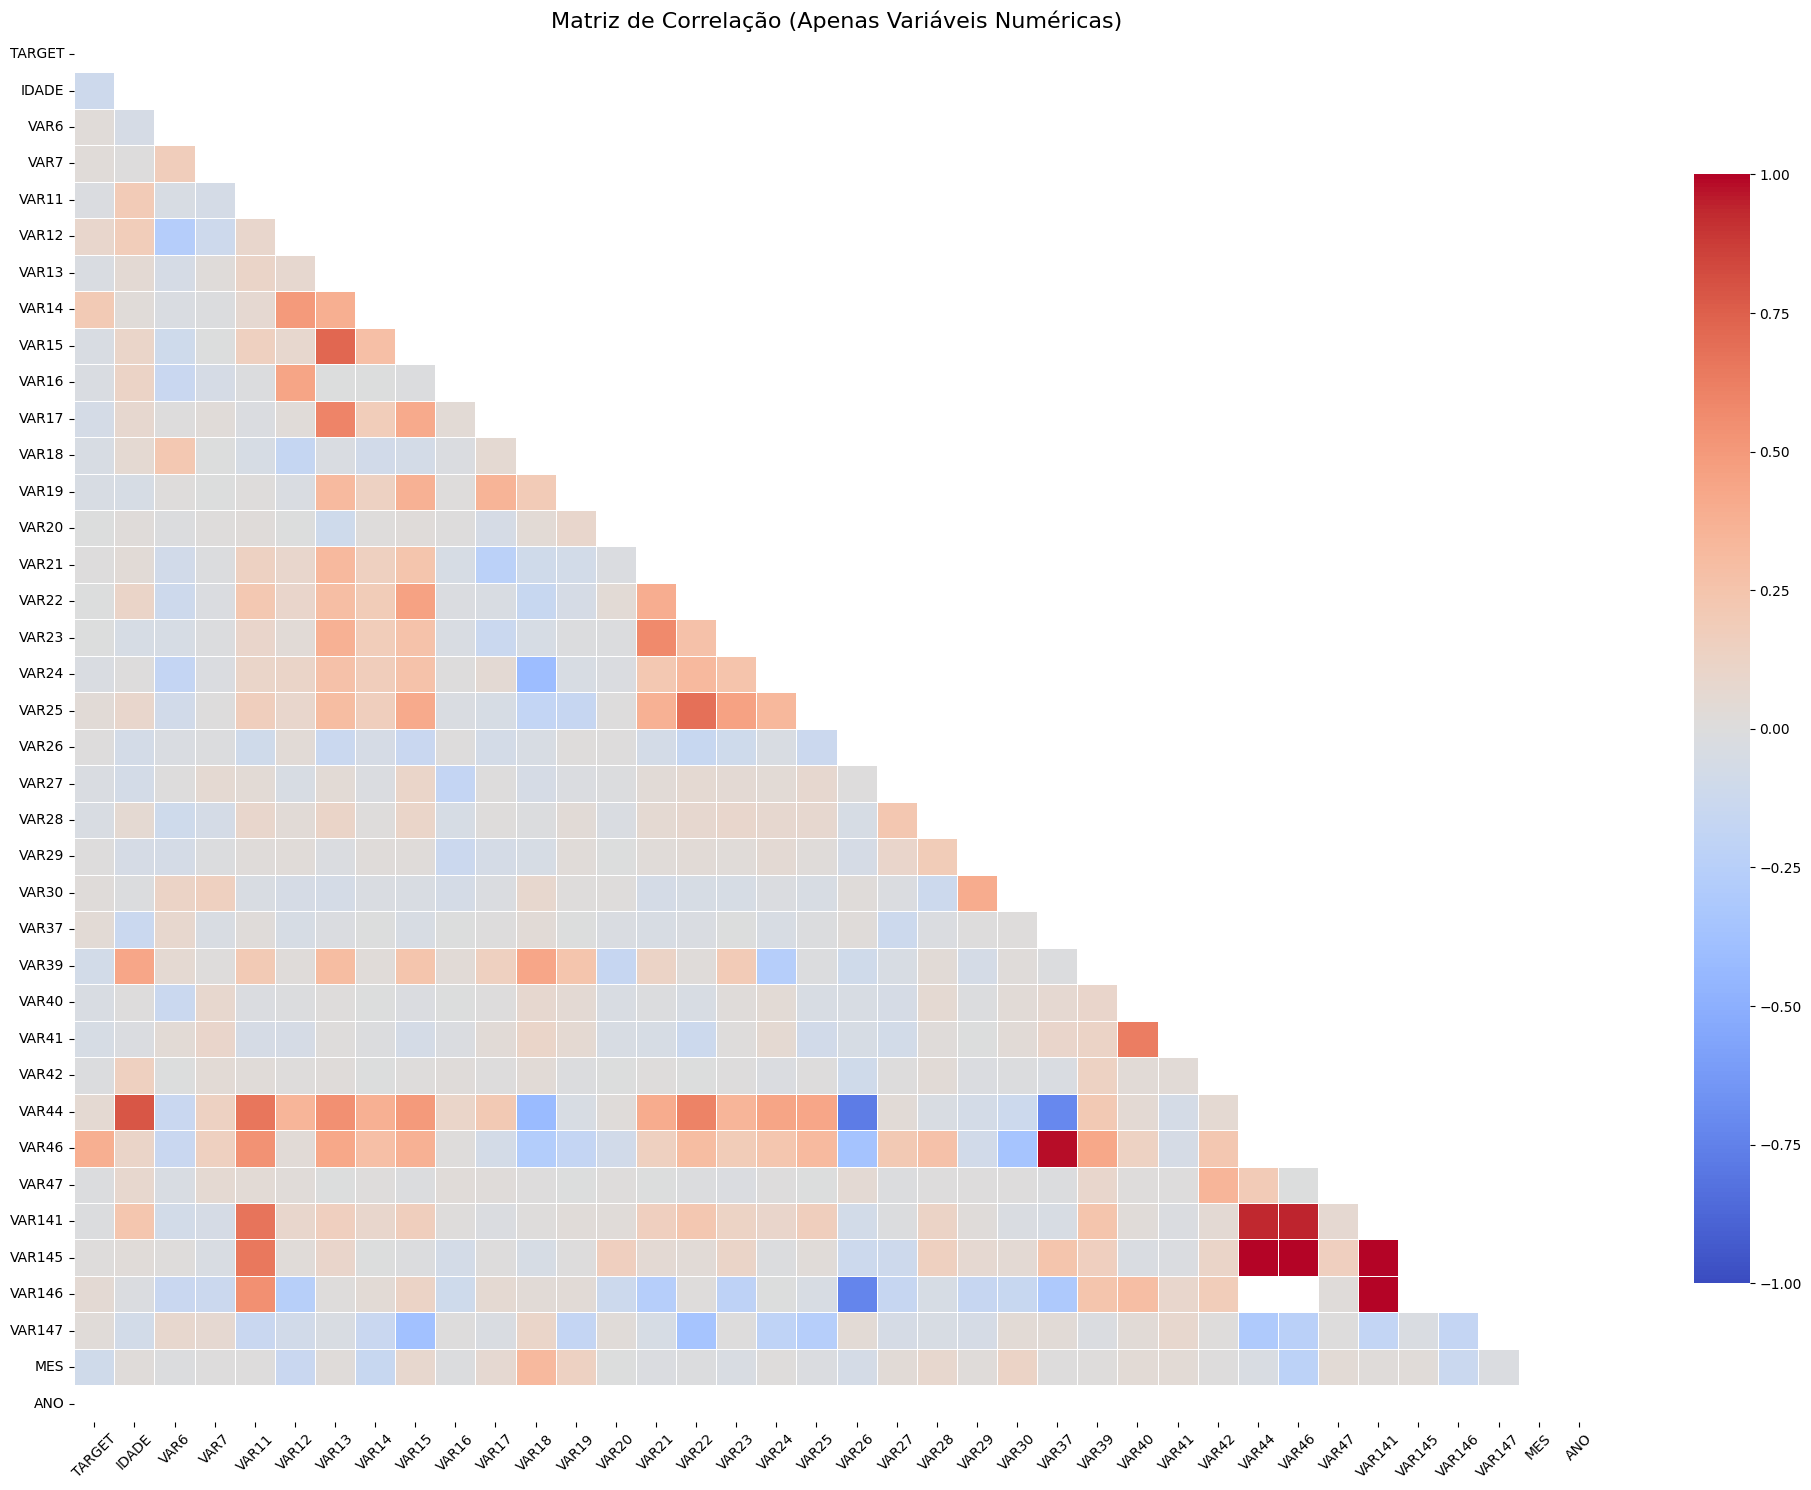

In [52]:
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()

exclude_cols = ['ID']
analysis_cols = [col for col in numeric_cols if col not in exclude_cols]

corr_matrix = df_train[analysis_cols].corr()

plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
           mask=mask,
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           annot=False,
           linewidths=0.5,
           cbar_kws={'shrink': 0.8})

plt.title('Matriz de Correlação (Apenas Variáveis Numéricas)', fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [54]:
print(df_train.duplicated().sum())

0


In [55]:
print(df_train.isnull().sum())


REF_DATE         0
TARGET           0
VAR2         14619
IDADE        13710
VAR4        120548
             ...  
VAR148           0
VAR149           0
ID               0
MES              0
ANO              0
Length: 153, dtype: int64


In [56]:
missing = df_train.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

VAR146    0.998609
VAR4      0.998327
VAR45     0.997565
VAR46     0.997565
VAR43     0.996679
            ...   
VAR138    0.024340
VAR134    0.024340
VAR133    0.024340
VAR142    0.001366
VAR39     0.000588
Length: 143, dtype: float64


In [57]:
cols_to_drop = df_train.isnull().mean()[lambda x: x > 0.95].index.tolist()
df_train.drop(columns=cols_to_drop, inplace=True)

print(f"Colunas removidas: {cols_to_drop}")

Colunas removidas: ['VAR4', 'VAR26', 'VAR27', 'VAR31', 'VAR38', 'VAR43', 'VAR44', 'VAR45', 'VAR46', 'VAR143', 'VAR144', 'VAR145', 'VAR146']


In [63]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['REF_DATE', 'ID']]

In [64]:
metadata = pd.DataFrame(df_train.dtypes, columns = ['tipo'])

metadata['n_categorias'] = 0

for var in metadata.index:
    metadata.loc[var,'n_categorias'] = len(df_train.groupby([var]).size())
    
metadata

,tipo,n_categorias
REF_DATE,"datetime64[ns, UTC]",242
TARGET,int64,2
VAR2,object,2
IDADE,float64,21847
VAR5,object,27
...,...,...
VAR148,object,8
VAR149,object,1
ID,int64,120750
MES,int32,8


In [73]:
metadata = pd.DataFrame(df_train.dtypes, columns=['tipo'])

metadata['n_categorias'] = [len(df_train[col].unique()) for col in df_train.columns]
metadata_asc = metadata.sort_values(by='n_categorias', ascending=True)
metadata_desc = metadata.sort_values(by='n_categorias', ascending=False)

print("\nVariáveis com menor complexidade:")
display(metadata_asc.head(10))

print("\nVariáveis com maior complexidade:")
display(metadata_desc.head(10))


Variáveis com menor complexidade:


,tipo,n_categorias
VAR149,object,1
ANO,int32,1
TARGET,int64,2
VAR33,object,2
VAR35,object,2
VAR147,int64,2
VAR36,object,2
VAR61,object,3
VAR49,object,3
VAR50,object,3



Variáveis com maior complexidade:


,tipo,n_categorias
ID,int64,120750
VAR39,float64,72143
VAR6,float64,51617
VAR7,float64,51586
VAR41,float64,44263
VAR42,float64,31149
VAR40,float64,31087
IDADE,float64,21848
VAR17,float64,2429
VAR19,float64,1951


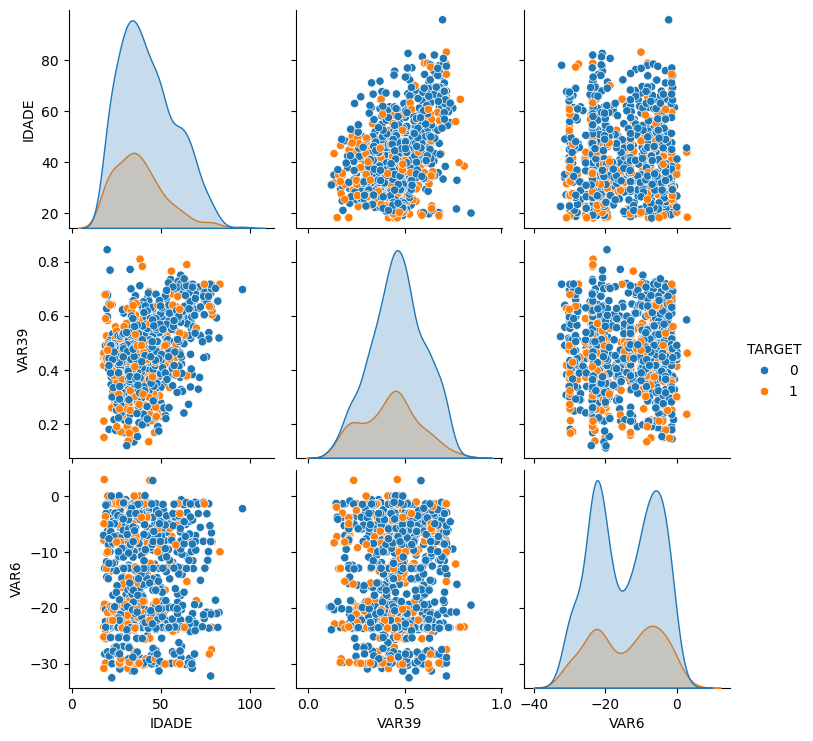

In [77]:
sns.pairplot(df_train[['IDADE','VAR39','VAR6','TARGET']].sample(1000), hue='TARGET')

In [89]:
#Converter REF_DATE para datetime
df_train['REF_DATE'] = pd.to_datetime(df_train['REF_DATE'])
df_test['REF_DATE'] = pd.to_datetime(df_test['REF_DATE'])

#Filtrar apenas agosto de 2017 na base de teste
df_test_aug = df_test[df_test['REF_DATE'].dt.month == 8]
df_test_aug = df_test_aug[df_test_aug['REF_DATE'].dt.year == 2017].copy()

#Remover REF_DATE e ID do treino e teste
drop_cols = ['REF_DATE', 'ID']
X_train = df_train.drop(columns=drop_cols + ['TARGET'])
y_train = df_train['TARGET']
X_test = df_test_aug.drop(columns=drop_cols + ['TARGET'])
y_test = df_test_aug['TARGET']

# Tratar variáveis categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

In [90]:
model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['IDADE', 'VAR6', 'VAR7',
                                                   'VAR11', 'VAR12', 'VAR13',
                                                   'VAR14', 'VAR15', 'VAR16',
                                                   'VAR17', 'VAR18', 'VAR19',
                                                   'VAR20', 'VAR21', 'VAR22',
                                                   'VAR23', 'VAR24', 'VAR25',
                                                   'VAR28', 'VAR29', 'VAR30',
                                                   'VAR37', 'VAR39', 'VAR40',
                                                   'VAR41', 'VAR42', 'VAR47',
                                                   'VAR141', 'VAR147']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='...
                                                                sparse_output=False),
                                                  ['VAR2', 'VAR5', 'VAR8',
                                                   'VAR9', 'VAR10', 'VAR32',
                                                   'VAR33', 'VAR34', 'VAR35',
                                                   'VAR36', 'VAR48', 'VAR49',
                                                   'VAR50', 'VAR51', 'VAR52',
                                                   'VAR53', 'VAR54', 'VAR55',
                                                   'VAR56', 'VAR57', 'VAR58',
                                                   'VAR59', 'VAR60', 'VAR61',
                                                   'VAR62', 'VAR63', 'VAR64',
                                                   'VAR65', 'VAR66', 'VAR67', ...])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [91]:
# Score de probabilidade de "bom pagador" (classe 0)
score = model.predict_proba(X_test)[:, 0]  # 0 = bom pagador, 1 = inadimplente

# Política AS-IS: aprova só quem tem idade > 28
aprovados_asis = df_test_aug[df_test_aug['IDADE'] > 28]
carteira_asis = len(aprovados_asis) * 1000
divida_asis = aprovados_asis.query('TARGET == 1').shape[0] * 1000
percentual_negados = 1 - (len(aprovados_asis) / len(df_test_aug))

print(f"Carteira aprovada AS-IS: R$ {carteira_asis:,.2f}")
print(f"Dívida total AS-IS: R$ {divida_asis:,.2f}")
print(f"Percentual negados AS-IS: {percentual_negados:.2%}")

# Política TO-BE: nega o mesmo percentual de pessoas, mas pelo score
score_cut = np.percentile(score, percentual_negados * 100)
aprovados_tobe = df_test_aug[score >= score_cut]
carteira_tobe = len(aprovados_tobe) * 1000
divida_tobe = aprovados_tobe.query('TARGET == 1').shape[0] * 1000

print(f"Carteira aprovada TO-BE: R$ {carteira_tobe:,.2f}")
print(f"Dívida total TO-BE: R$ {divida_tobe:,.2f}")
print(f"Economia gerada: R$ {divida_asis - divida_tobe:,.2f}")

Carteira aprovada AS-IS: R$ 5,432,000.00
Dívida total AS-IS: R$ 863,000.00
Percentual negados AS-IS: 25.64%
Carteira aprovada TO-BE: R$ 5,643,000.00
Dívida total TO-BE: R$ 878,000.00
Economia gerada: R$ -15,000.00
